# Week 13 Notebook: Forecasting Rideshare Prices in Boston
The goal of this week's assignment is create a comprehensive report of the rideshare price predictive project we conducted this semester. 

## Problem Definition
We aimed to develop a predictive model that accurately forecasts rideshare prices in Boston during the months of November and December, utilizing a range of key features such as time of day, day of the week, source, destination, distance, temperature, and other weather-related features. Our focus is on predicting the cost of Uber and Lyft rides by analyzing how these situational and environmental factors influence pricing. 

The dataset, sourced from Kaggle, contains about 690,000 rows of data from November and December 2018. The project will eventually focus on approximately 100,000 observations from the original dataset. This subset will be identified either by focusing on a single company or ride type, or through random or stratified sampling. Since the data spans only two months, the model’s predictions are limited to this time frame. While it may not generalize to other periods, the goal is to build a model that performs well on this dataset and reveals key patterns in rideshare pricing. 

The notebook is going to walk through the whole model development life cycle over the span of 12 weeks.


### Import packages

In [1]:
import os
import pickle
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, root_mean_squared_error

In [2]:
from helper_function import train_val_test_split, weather_severity, add_time_features 
from helper_function import shift_dt, calculate_taxi_price
from helper_function import OneHotEncodingProcessor
from helper_function import evaluate_model, evaluate_model_v2, mean_squared_error
from helper_function import save_model, load_model

## ETL Pipeline
#### Directory Setup

In [3]:
# Get the parent directory of the current directory
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

# Define the paths for model folder and data folder
model_folder = os.path.join(parent_dir,"models")
data_folder = os.path.join(parent_dir,"data")

# Define the paths for raw, interim and processed data folders
raw_data_folder = os.path.join(data_folder,"raw")
interim_data_folder = os.path.join(data_folder,"interim")
processed_data_folder = os.path.join(data_folder, "processed")

### Load Raw Data File as DataFrame

In [4]:
# Define the path for raw data file
raw_data_file = os.path.join(raw_data_folder, 'rawSampledData.csv')

# Load the data as a pandas dataframe.
df = pd.read_csv(raw_data_file)

In [5]:
# Change the `datetime` column into datetime datatype
df['datetime'] = pd.to_datetime(df['datetime'])

### Data Partition
- training set is 70% of the dataframe
- validation set is 20% of the dataframe
- test set is 10% of the dataframe

In [6]:
train_df, val_df, test_df = train_val_test_split(df)

## Exploratory Data Analysis
### Data types

In [7]:
cat_col = [col for col in df.columns if df[col].dtype == 'object']
num_col = [col for col in df.columns if col not in cat_col]

# Remove 'id' and 'datetime' from the list of column names
num_col = [col for col in num_col if col not in ['id', 'datetime']]

print(f"cat_col = {len(cat_col)}\nnum_col = {len(num_col)}\n")

cat_col = 9
num_col = 46



### Missing Value Investigation
As shown in the code below, the target variable `price` has 5623 missing values in the training set, which we need to decide how to deal with in data preparation. Upon further investigation, all the missing values are associated with Uber rides labeled ‘Taxi.’ To impute missing value, we have found the taxi fare breakdown in our Uber app, and the process is demonstrated in the "Data Preprocessing" section.

In [8]:
print(train_df.isnull().sum())

datetime                          0
timestamp                         0
hour                              0
day                               0
month                             0
timezone                          0
source                            0
destination                       0
cab_type                          0
product_id                        0
name                              0
price                          5623
distance                          0
surge_multiplier                  0
latitude                          0
longitude                         0
temperature                       0
apparentTemperature               0
short_summary                     0
long_summary                      0
precipIntensity                   0
precipProbability                 0
humidity                          0
windSpeed                         0
windGust                          0
windGustTime                      0
visibility                        0
temperatureHigh             

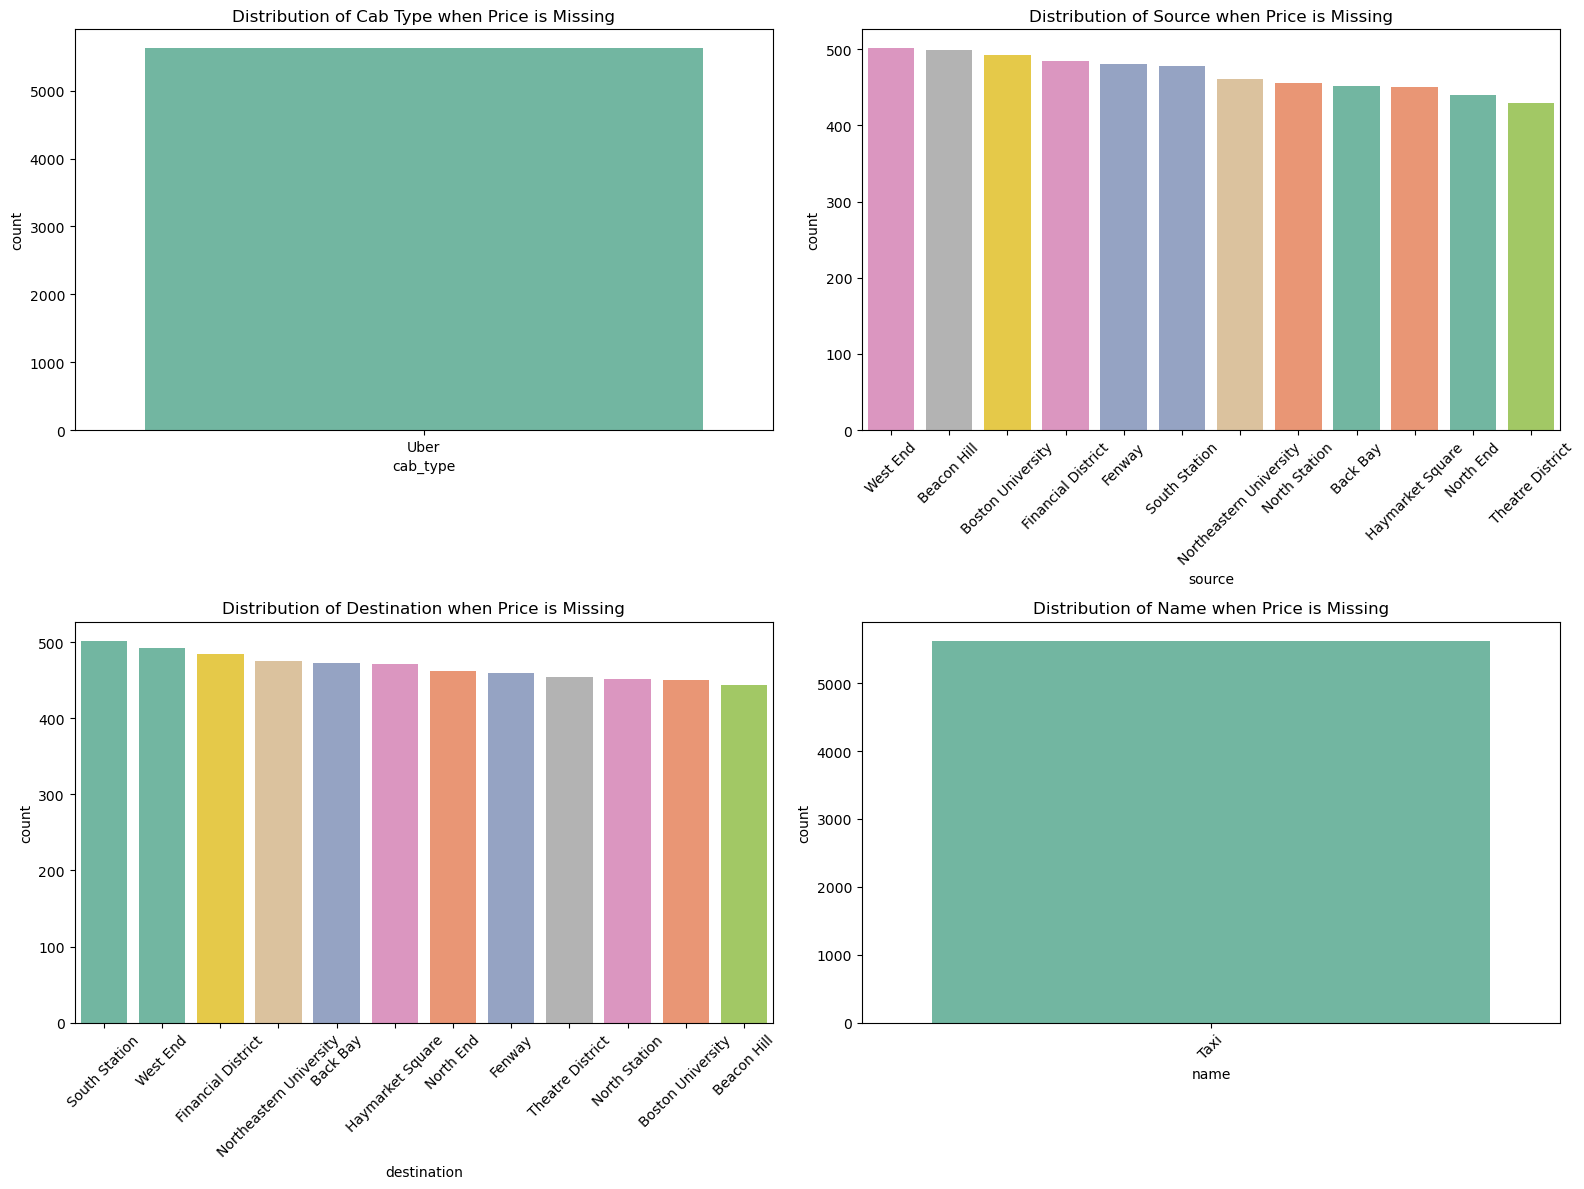

In [9]:
df_na = train_df[train_df['price'].isna()]

# Set up a 3x2 grid for subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Distribution of 'cab_type' when 'price' is missing
sns.countplot(x='cab_type', hue='cab_type', data=df_na, palette='Set2', ax=axes[0, 0])
axes[0, 0].set_title('Distribution of Cab Type when Price is Missing')

# Distribution of 'source' when 'price' is missing
sns.countplot(x='source', hue='source', data=df_na, palette='Set2', order=df_na['source'].value_counts().index, ax=axes[0, 1])
axes[0, 1].set_title('Distribution of Source when Price is Missing')
axes[0, 1].tick_params(axis='x', rotation=45)

# Distribution of 'destination' when 'price' is missing
sns.countplot(x='destination', hue='destination', data=df_na, palette='Set2', order=df_na['destination'].value_counts().index, ax=axes[1, 0])
axes[1, 0].set_title('Distribution of Destination when Price is Missing')
axes[1, 0].tick_params(axis='x', rotation=45)

# Distribution of 'name' when 'price' is missing
sns.countplot(x='name', hue='name', data=df_na, palette='Set2', order=df_na['name'].value_counts().index, ax=axes[1, 1])
axes[1, 1].set_title('Distribution of Name when Price is Missing')
axes[1, 1].tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()


### Correlation Analysis
A lot of variables exhibit high correlation, and high correlation among variables can lead to multicollinearity, which can affect the performance and interpretability of regression models. It also indicates needs for feature engineering. We have explored several methods depends on the model, and for our final model, we used regularization tov address this issue.

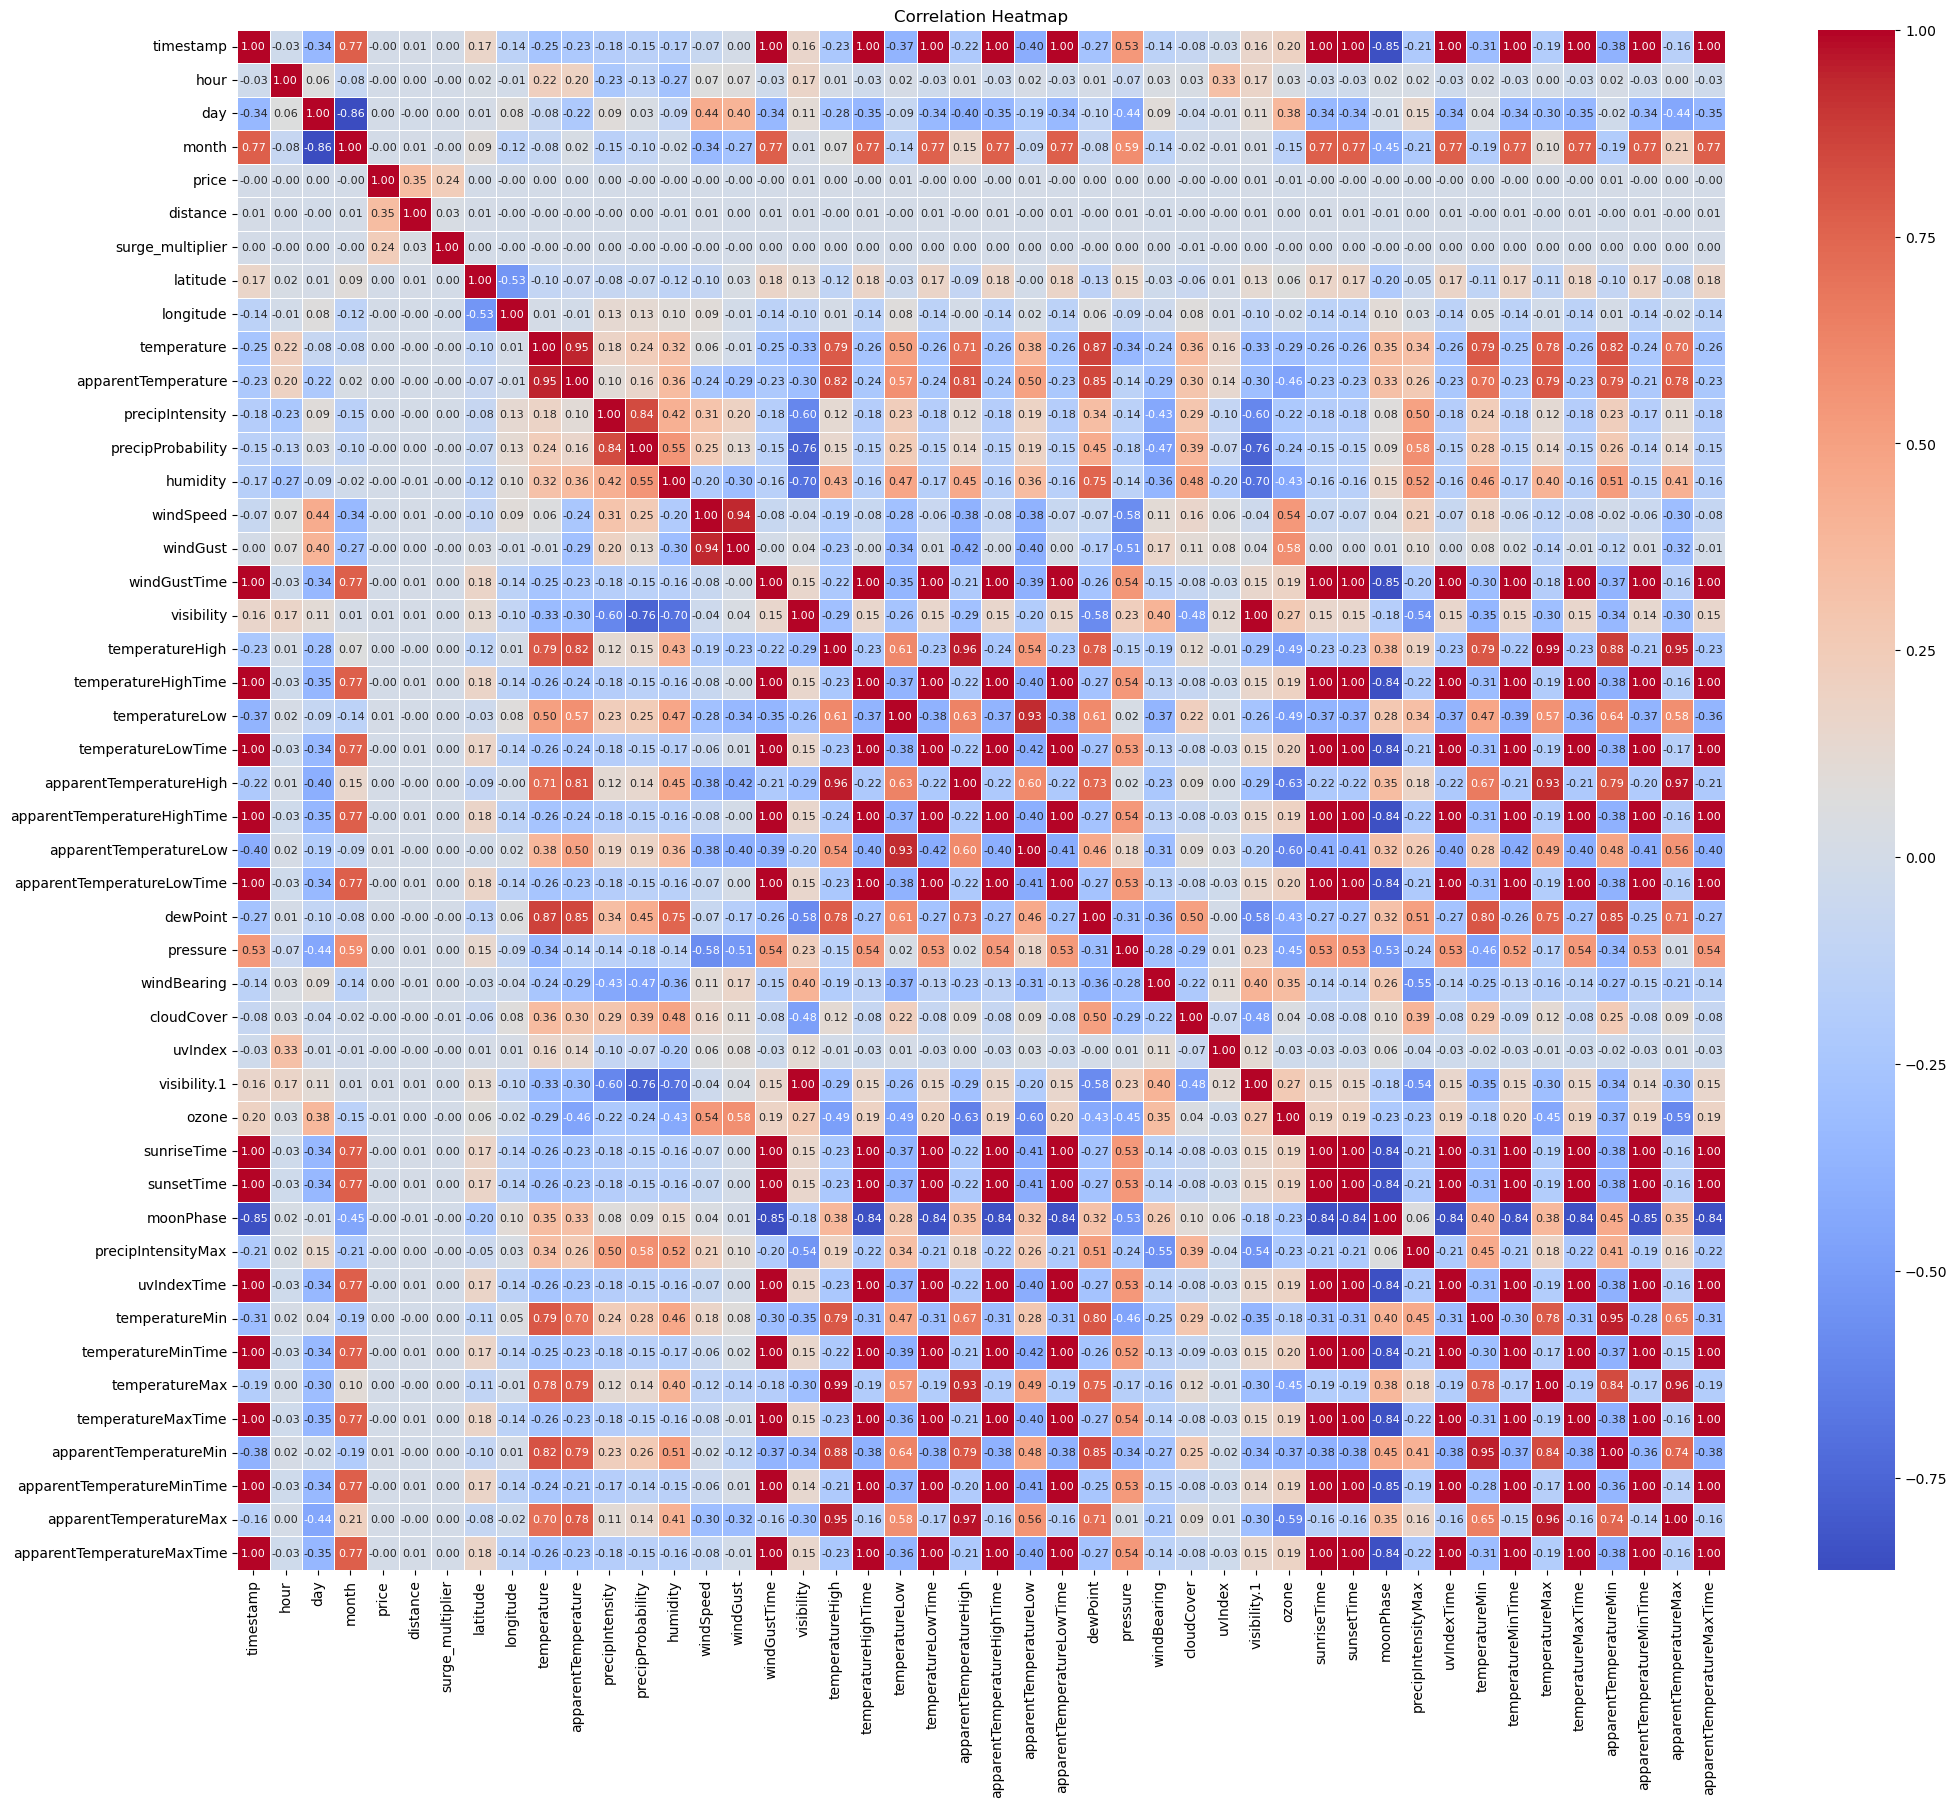

In [10]:
num_df = df[num_col]
correlation_matrix = num_df.corr()
# Create a heatmap
plt.figure(figsize=(24, 20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, annot_kws={"size": 8})
plt.title('Correlation Heatmap')
plt.show()

## Feature Engineering
### Create new variables
#### Weather-related Variable
We created a custom weighting system by assigning scores to each type of weather event based on severity or relevance. We weight it by evaluating the weather conditions, considering all three variables and visibility as visibility plays a significant role in determining whether weather conditions will impact driving safety. 

In order to calculate the weight, we first needed to understand how these variables reflect the weather on that specific date and assess how severe the conditions are for driving.

In [11]:
train_df['weather_severity'] = train_df.apply(lambda row: weather_severity(row), axis=1)
val_df['weather_severity'] = val_df.apply(lambda row: weather_severity(row), axis=1)
test_df['weather_severity'] = test_df.apply(lambda row: weather_severity(row), axis=1)

#### Time-related Variable
We also added the following time related variables in week 5. 

In [12]:
train_df = add_time_features(train_df)
val_df = add_time_features(val_df)
test_df = add_time_features(test_df)

## Data Preprocessing
Since we conducted feature engineering on the original data before preprocessing, we will run the pipeline again to get the prepare the data for modeling

### Missing Value Imputation
Uber Taxi Fee Breakdown
 - base fare: $2.60 for first 1/7 mile
 - per minute fare: $0.47
 - per mile: $2.8

Since the Taxi fee is calculated based on distance and time, we need to compute the duration of the ride which is not available in the dataset. However, we have access to the source, destination, and datetime when the ride is initiated, which gives us enough information to estimate the duration of each trip.

Steps to impute the missing value:
- Use `Geopy` to get the coordinates for both source and destination, which is saved as `data/interim/ride_locations.csv`.
- Use Mapbox API to get estimated ride duration, referred as `eta_minutes`, based on the coordinates and the datetime when the ride is initiated. The results were saved as `data/interim/rides_with_etas_rush_hour.csv`

To save computation time and resource, details regarding how those steps were implemented are stored in `codes/time_calculator_rush_hr.ipynb` and `codes/time_calculator.py`.


In [13]:
# Read the parquet file that contains the source, destination, datetime, and eta_minutes as a DataFrame
rides_with_eta_rh = os.path.join(interim_data_folder, "rides_with_etas_rush_hour.csv")
time_df = pd.read_parquet(rides_with_eta_rh)

In [14]:
# Preprocess the `datetime` variable to be match the format of the time_df
train_df = shift_dt(train_df)
val_df = shift_dt(val_df)
test_df = shift_dt(test_df)
# Calculate the taxi price based on distance and the estimated duration of each trip
train_df = calculate_taxi_price(train_df, time_df, rush_hour=True)
val_df = calculate_taxi_price(val_df, time_df, rush_hour=True)
test_df = calculate_taxi_price(test_df, time_df, rush_hour=True)

In [15]:
train_na = train_df[train_df['name']=="Taxi"]['price'].isnull().sum()
val_na = val_df[val_df['name']=="Taxi"]['price'].isnull().sum()
test_na = test_df[test_df['name']=="Taxi"]['price'].isnull().sum()
if train_na+val_na+test_na == 0:
    print('There is no missing value remained')
else:
    print('There are still missing values')

There is no missing value remained


### Drop Uneeded Columns
Some columns are not relevant for modeling because they function solely as unique identifiers and do not provide meaningful information for preduction purposes:
- `id`
- `product_id`

Additionally, we also dropped `timezone` since all data is within the same timezone.

`datetime` and`timestamp` were dropped to reduce redundacy with other time features.

`visibility.1` is duplicated with  `visibility`

In [16]:
columns_to_drop = ['timezone', 'datetime', 'product_id', 'visibility.1', 'timestamp','short_summary', 'long_summary', 'icon',  'latitude', 'longitude']

train_df = train_df.drop(columns=columns_to_drop)
val_df = val_df.drop(columns=columns_to_drop)
test_df = test_df.drop(columns=columns_to_drop)

We had previously dropped the variable `eta_minutes` as well, but we added this variable back in for week 10. We hope to identify whether including this variable improves the performance of our winning model, the pruned Decision Tree.

### Encoding Categorical Variables
#### Check dtypes

In [17]:
object_columns = train_df.select_dtypes(include=['object']).columns.tolist()

# Display the object columns
print("Object Columns:")
print(object_columns)

Object Columns:
['source', 'destination', 'cab_type', 'name']


#### Encoding `source` and `destination` variables

In [18]:
source_processor = OneHotEncodingProcessor(column_name='source', categories = None)

# Fit the processor on the training data
source_processor.fit(train_df)

# Transform the training, validation, and test datasets
train_df = source_processor.transform(train_df)
val_df = source_processor.transform(val_df)
test_df = source_processor.transform(test_df)

In [19]:
# Get the source encoder's categories
source_categories = source_processor.encoder.categories_[0]

# Initialize the destination_processor with predefined source categories
destination_processor=OneHotEncodingProcessor(column_name='destination', categories=source_categories)
destination_processor.fit(train_df)

train_df = destination_processor.transform(train_df)
val_df = destination_processor.transform(val_df)
test_df = destination_processor.transform(test_df)

#### Encoding 'name' and 'cab_type' variables

In [20]:
name_processor = OneHotEncodingProcessor(column_name='name')

# Fit the processor on the training data
name_processor.fit(train_df)

# Transform the training, validation, and test datasets
train_df = name_processor.transform(train_df)
val_df = name_processor.transform(val_df)
test_df = name_processor.transform(test_df)

In [21]:
train_df['cab_type'] = train_df['cab_type'].str.strip()
val_df['cab_type'] = val_df['cab_type'].str.strip()
test_df['cab_type'] = test_df['cab_type'].str.strip()

# Ensure there are no leading or trailing spaces in the 'cab_type' column
train_df['cab_type'] = train_df['cab_type'].str.strip()
val_df['cab_type'] = val_df['cab_type'].str.strip()
test_df['cab_type'] = test_df['cab_type'].str.strip()

# Create dummy variables for the 'cab_type' column
train_df = pd.get_dummies(train_df, columns=['cab_type'], drop_first=True)
val_df = pd.get_dummies(val_df, columns=['cab_type'], drop_first=True)
test_df = pd.get_dummies(test_df, columns=['cab_type'], drop_first=True)

#### Drop encoded categorical columns

In [22]:
cat_columns_to_drop = ['source',
 'destination',
 'name']

train_df = train_df.drop(columns = cat_columns_to_drop)
val_df = val_df.drop(columns = cat_columns_to_drop)
test_df = test_df.drop(columns = cat_columns_to_drop)

In [23]:
train_df.columns

Index(['hour', 'day', 'month', 'price', 'distance', 'surge_multiplier',
       'temperature', 'apparentTemperature', 'precipIntensity',
       'precipProbability', 'humidity', 'windSpeed', 'windGust',
       'windGustTime', 'visibility', 'temperatureHigh', 'temperatureHighTime',
       'temperatureLow', 'temperatureLowTime', 'apparentTemperatureHigh',
       'apparentTemperatureHighTime', 'apparentTemperatureLow',
       'apparentTemperatureLowTime', 'dewPoint', 'pressure', 'windBearing',
       'cloudCover', 'uvIndex', 'ozone', 'sunriseTime', 'sunsetTime',
       'moonPhase', 'precipIntensityMax', 'uvIndexTime', 'temperatureMin',
       'temperatureMinTime', 'temperatureMax', 'temperatureMaxTime',
       'apparentTemperatureMin', 'apparentTemperatureMinTime',
       'apparentTemperatureMax', 'apparentTemperatureMaxTime',
       'weather_severity', 'rush_hour', 'weekend', 'game_day', 'eta_minutes',
       'source_Back_Bay', 'source_Beacon_Hill', 'source_Boston_University',
       'sour

### Standardization
We standardize our data for faster convergence.

In [24]:
y_train = train_df[['price']]
y_val = val_df[['price']]
y_test = test_df[['price']]

X_train = train_df.drop('price', axis = 1)
X_val = val_df.drop('price', axis = 1)
X_test = test_df.drop('price', axis = 1)

In [25]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.fit_transform(X_val)
X_test_scaled = scaler.fit_transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

## Model Selection and Model Training
We built, trained, and assessed ten models over the course of the project:
- OLS Regression
- OLS Regression with PCA
- Lasso Regression (with varying regularization strengths)
- Ridge Regression (with varying regularization strengths)
- Basic Decision Tree
- Tuned Decision Tree (via grid search and cross-validation)
- Pruned Decision Tree
- Random Forest 1 (100 estimators, max depth = 15)
- Random Forest 2 (200 estimators, max depth = 15)
- Random Forest 3 (2200 estimators, max depth = 10)

Among the 10 models, pruned decision tree stands out in terms of bias and variance tradeoff. The following code block showcases how the decision tree was trained on improved data, and the parameters are determined using unimproved data and cross validation. We are going to further tune the model for the improved data in later section.

In [26]:
dtr = DecisionTreeRegressor(
    max_depth=20,
    min_samples_split=7,
    min_samples_leaf=10,
    ccp_alpha=0.001,
    random_state=42
)

# Fit the model to the training data
dtr.fit(X_train_scaled, y_train)


DecisionTreeRegressor(ccp_alpha=0.001, max_depth=20, min_samples_leaf=10,
                      min_samples_split=7, random_state=42)

## Model Evaluation

In [27]:
# Evaluate performance for the first decision tree (dtr)
train_mse_tree, train_rmse_tree, train_r2_tree = evaluate_model(dtr, X_train_scaled, y_train)
val_mse_tree, val_rmse_tree, val_r2_tree = evaluate_model(dtr, X_val_scaled, y_val)
test_mse_tree, test_rmse_tree, test_r2_tree = evaluate_model(dtr, X_test_scaled, y_test)

# Print training metrics for dtr
print("Decision Tree Regression Model (dtr) - Training Metrics:")
print(f"MSE: {train_mse_tree:.4f}, RMSE: {train_rmse_tree:.4f}, R²: {train_r2_tree:.4f}")

# Print validation metrics for dtr
print("\nDecision Tree Regression Model (dtr) - Validation Metrics:")
print(f"MSE: {val_mse_tree:.4f}, RMSE: {val_rmse_tree:.4f}, R²: {val_r2_tree:.4f}")

# Print test metrics for dtr
print("\nDecision Tree Regression Model (dtr) - Test Metrics:")
print(f"MSE: {test_mse_tree:.4f}, RMSE: {test_rmse_tree:.4f}, R²: {test_r2_tree:.4f}")


Decision Tree Regression Model (dtr) - Training Metrics:
MSE: 2.6845, RMSE: 1.6385, R²: 0.9675

Decision Tree Regression Model (dtr) - Validation Metrics:
MSE: 3.0972, RMSE: 1.7599, R²: 0.9622

Decision Tree Regression Model (dtr) - Test Metrics:
MSE: 3.0410, RMSE: 1.7439, R²: 0.9637


## Model Tuning

In [28]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

# Define the model
dtr = DecisionTreeRegressor(random_state=42)

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'max_depth': [20, 23, 25],
    'min_samples_split': [5, 7, 10],
    'min_samples_leaf': [5, 10, 15],
    'ccp_alpha': [0.001, 0.01, 0.1]
}

# Perform Grid Search with 5-fold cross-validation
grid_search = GridSearchCV(estimator=dtr, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

# Fit the grid search model to the training data
grid_search.fit(X_train_scaled, y_train)

# Get the best parameters and the best estimator
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Display the results
print("Best Parameters:", best_params)
print("Best Model:", best_model)


Fitting 5 folds for each of 81 candidates, totalling 405 fits


Best Parameters: {'ccp_alpha': 0.001, 'max_depth': 20, 'min_samples_leaf': 10, 'min_samples_split': 5}
Best Model: DecisionTreeRegressor(ccp_alpha=0.001, max_depth=20, min_samples_leaf=10,
                      min_samples_split=5, random_state=42)


In [29]:
# Evaluate performance for the best decision tree model (best_model)
train_mse_best, train_rmse_best, train_r2_best = evaluate_model(best_model, X_train_scaled, y_train)
val_mse_best, val_rmse_best, val_r2_best = evaluate_model(best_model, X_val_scaled, y_val)
test_mse_best, test_rmse_best, test_r2_best = evaluate_model(best_model, X_test_scaled, y_test)

# Print training metrics for the best model
print("Best Decision Tree Regression Model - Training Metrics:")
print(f"MSE: {train_mse_best:.4f}, RMSE: {train_rmse_best:.4f}, R²: {train_r2_best:.4f}")

# Print validation metrics for the best model
print("\nBest Decision Tree Regression Model - Validation Metrics:")
print(f"MSE: {val_mse_best:.4f}, RMSE: {val_rmse_best:.4f}, R²: {val_r2_best:.4f}")

# Print test metrics for the best model
print("\nBest Decision Tree Regression Model - Test Metrics:")
print(f"MSE: {test_mse_best:.4f}, RMSE: {test_rmse_best:.4f}, R²: {test_r2_best:.4f}")


Best Decision Tree Regression Model - Training Metrics:
MSE: 2.6845, RMSE: 1.6385, R²: 0.9675

Best Decision Tree Regression Model - Validation Metrics:
MSE: 3.0972, RMSE: 1.7599, R²: 0.9622

Best Decision Tree Regression Model - Test Metrics:
MSE: 3.0410, RMSE: 1.7439, R²: 0.9637


## Model Deployment

### Serializing the model with pickle

### Saving and loading the data

In [30]:
# Paths for feature variables
X_train_path = os.path.join(processed_data_folder, 'X_train.parquet')
X_val_path = os.path.join(processed_data_folder, 'X_val.parquet')
X_test_path = os.path.join(processed_data_folder, 'X_test.parquet')

# Paths for the target variables
y_train_path = os.path.join(processed_data_folder, 'y_train.parquet')
y_val_path = os.path.join(processed_data_folder, 'y_val.parquet')
y_test_path = os.path.join(processed_data_folder, 'y_test.parquet')

# Paths for models
model_path = os.path.join(model_folder, 'week13_model.pkl')


In [31]:
# Save cleaned data to CSV
def save_data(df, file_path):
    """
    Save a DataFrame to a CSV file.
    Dependencies: pandas
    """
    df.to_parquet(file_path, index=False)
    print(f"Data saved to {file_path}")

def load_data(file_path):
    """
    Load data from a CSV file into a DataFrame.
    Dependencies: pandas
    """
    df = pd.read_parquet(file_path)
    print(f"Data loaded from {file_path}")
    return df


In [35]:
# Save the cleaned training data
save_data(X_train_scaled, X_train_path)
save_data(X_val_scaled, X_val_path)
save_data(X_test_scaled, X_test_path)

save_data(y_train, y_train_path)
save_data(y_val, y_val_path)
save_data(y_test, y_test_path)

# Save the retrained pruned decision tree model
save_model(best_model, model_path)

Data saved to /Users/carriexia/Documents/GitHub/ADAN8888.01_Fall_24_Applied_Analytics_Project/data/processed/X_train.parquet
Data saved to /Users/carriexia/Documents/GitHub/ADAN8888.01_Fall_24_Applied_Analytics_Project/data/processed/X_val.parquet
Data saved to /Users/carriexia/Documents/GitHub/ADAN8888.01_Fall_24_Applied_Analytics_Project/data/processed/X_test.parquet
Data saved to /Users/carriexia/Documents/GitHub/ADAN8888.01_Fall_24_Applied_Analytics_Project/data/processed/y_train.parquet
Data saved to /Users/carriexia/Documents/GitHub/ADAN8888.01_Fall_24_Applied_Analytics_Project/data/processed/y_val.parquet
Data saved to /Users/carriexia/Documents/GitHub/ADAN8888.01_Fall_24_Applied_Analytics_Project/data/processed/y_test.parquet
Model saved to /Users/carriexia/Documents/GitHub/ADAN8888.01_Fall_24_Applied_Analytics_Project/models/week13_model.pkl


In [36]:
# Load the saved model and data for verification
loaded_model = load_model(model_path)
loaded_data = load_data(X_train_path)

Model loaded from /Users/carriexia/Documents/GitHub/ADAN8888.01_Fall_24_Applied_Analytics_Project/models/week13_model.pkl
Data loaded from /Users/carriexia/Documents/GitHub/ADAN8888.01_Fall_24_Applied_Analytics_Project/data/processed/X_train.parquet


### Evaluate the loaded model on the test set

In [38]:
# Test the loaded model on the test set
X_test = load_data(X_test_path)
y_test = load_data(y_test_path)

loaded_test_mse, loaded_test_rmse, loaded_test_r2 = evaluate_model(model = loaded_model, X = X_test, y_true=y_test)
# Print evaluation metrics for the loaded model
print("\nEvaluation of Loaded Model:")
print(f"MSE: {loaded_test_mse:.4f}, RMSE: {loaded_test_rmse:.4f}, R²: {loaded_test_r2:.4f}")

Data loaded from /Users/carriexia/Documents/GitHub/ADAN8888.01_Fall_24_Applied_Analytics_Project/data/processed/X_test.parquet
Data loaded from /Users/carriexia/Documents/GitHub/ADAN8888.01_Fall_24_Applied_Analytics_Project/data/processed/y_test.parquet

Evaluation of Loaded Model:
MSE: 10777.7599, RMSE: 103.8160, R²: -0.0160


In [43]:
def get_versions():
    versions = {
        "Python Version": sys.version,
        "pandas": pd.__version__,
        "numpy": np.__version__,
        "matplotlib": plt.matplotlib.__version__,
        "seaborn": sns.__version__,
        "scikit-learn": None,
        "os": "Built-in",
        "zipfile": "Built-in",
        "pickle": "Built-in"
    }
    try:
        import sklearn
        versions["scikit-learn"] = sklearn.__version__
    except ImportError:
        versions["scikit-learn"] = "Not Installed"
    
    return versions

versions = get_versions()
versions

{'Python Version': '3.11.6 | packaged by conda-forge | (main, Oct  3 2023, 10:37:07) [Clang 15.0.7 ]',
 'pandas': '2.2.3',
 'numpy': '1.24.3',
 'matplotlib': '3.7.2',
 'seaborn': '0.13.2',
 'scikit-learn': '1.5.2',
 'os': 'Built-in',
 'zipfile': 'Built-in',
 'pickle': 'Built-in'}